<a href="https://colab.research.google.com/github/Orden-Aurea/aether-resilient-protocol/blob/main/aether_por_proto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

nodos=5, latencia=0.05s -> tiempo=0.1012s
nodos=10, latencia=0.05s -> tiempo=0.1016s
nodos=30, latencia=0.05s -> tiempo=0.1026s
nodos=60, latencia=0.05s -> tiempo=0.1059s
nodos=100, latencia=0.05s -> tiempo=0.1080s
nodos=5, latencia=0.2s -> tiempo=0.4013s
nodos=10, latencia=0.2s -> tiempo=0.4018s
nodos=30, latencia=0.2s -> tiempo=0.4030s
nodos=60, latencia=0.2s -> tiempo=0.4053s
nodos=100, latencia=0.2s -> tiempo=0.4084s
nodos=5, latencia=0.5s -> tiempo=1.0019s
nodos=10, latencia=0.5s -> tiempo=1.0027s
nodos=30, latencia=0.5s -> tiempo=1.0052s
nodos=60, latencia=0.5s -> tiempo=1.0058s
nodos=100, latencia=0.5s -> tiempo=1.0090s


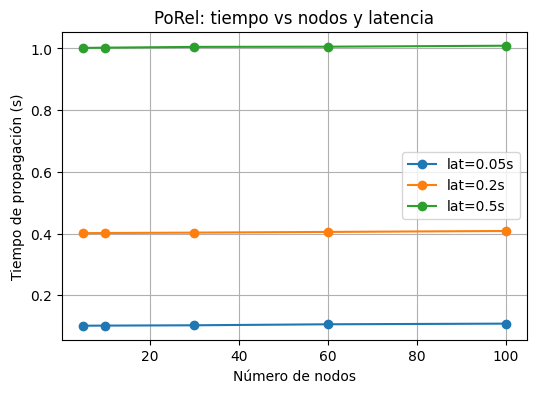

In [9]:
import asyncio
import time
import hashlib
from dataclasses import dataclass, field
from typing import List, Set
import matplotlib.pyplot as plt

from cryptography.hazmat.primitives.asymmetric.ed25519 import Ed25519PrivateKey

@dataclass
class Tx:
    id: str
    payload: str
    relay_signers: Set[int] = field(default_factory=set)

class Node:
    def __init__(self, node_id: int, network_latency: float = 0.05):
        self.id = node_id
        self.private_key = Ed25519PrivateKey.generate()
        self.public_key = self.private_key.public_key()
        self.latency = network_latency
        self.peers: List["Node"] = []

    def connect(self, other: "Node"):
        if other not in self.peers:
            self.peers.append(other)

    async def receive_tx(self, tx: Tx, k_threshold: int):
        if self.id in tx.relay_signers:
            return

        await asyncio.sleep(self.latency)
        tx.relay_signers.add(self.id)

        if len(tx.relay_signers) >= k_threshold:
            return

        tasks = []
        for p in self.peers:
            tasks.append(asyncio.create_task(p.receive_tx(tx, k_threshold)))
        if tasks:
            await asyncio.gather(*tasks)

async def run_por_once(num_nodes: int, k_threshold: int, latency: float) -> float:
    nodes = [Node(i, network_latency=latency) for i in range(num_nodes)]

    # full mesh
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                nodes[i].connect(nodes[j])

    payload = "tx_aether_demo"
    tx_id = hashlib.sha256(payload.encode()).hexdigest()[:8]
    tx = Tx(id=tx_id, payload=payload)

    start = time.time()
    await nodes[0].receive_tx(tx, k_threshold)
    elapsed = time.time() - start
    return elapsed

async def experiment_por():
    # ACA SOLO TOCAS ESTOS TRES VALORES:
    num_nodes_list = [5, 10, 30, 60, 100]
    latency_list = [0.05, 0.2, 0.5]
    k_threshold = 10

    results = []

    for latency in latency_list:
        for n in num_nodes_list:
            elapsed = await run_por_once(n, k_threshold, latency)
            print(f"nodos={n}, latencia={latency}s -> tiempo={elapsed:.4f}s")
            results.append((n, latency, elapsed))

    plt.figure(figsize=(6,4))
    for latency in latency_list:
        xs = [n for (n, L, t) in results if L == latency]
        ys = [t for (n, L, t) in results if L == latency]
        plt.plot(xs, ys, marker="o", label=f"lat={latency}s")

    plt.xlabel("Número de nodos")
    plt.ylabel("Tiempo de propagación (s)")
    plt.title("PoRel: tiempo vs nodos y latencia")
    plt.legend()
    plt.grid(True)
    plt.show()

await experiment_por()
